In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "reciprocate/dahoas-gptj-rm-static"
model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/sae-rm/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]/root/sae-rm/logan/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


In [2]:

# import sys
# sys.path.append("/root/dictionary_learning/")
from dictionary import GatedAutoEncoder

layer = 2
activation_name = f"transformer.h.{layer}"
sae_file = f"saes/ae_layer{layer}.pt"
ae = GatedAutoEncoder.from_pretrained(sae_file).to(device)

In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch 
hh = load_dataset("Anthropic/hh-rlhf", split="train")
token_length_cutoff = 870 # 99% of chosen data

# Remove datapoints longer than a specific token_length
# Check if file exists
index_file_name = "rm_save_files/index_small_enough.pt"
dataset_size = hh.num_rows
if os.path.exists(index_file_name):
    index_small_enough = torch.load(index_file_name)
else:
    print("hey")
#     index_small_enough = torch.ones(dataset_size, dtype=torch.bool)
# # 
#     for ind, text in enumerate(tqdm(hh)):
#         chosen_text = text["chosen"]
#         rejected_text = text["rejected"]
#         #convert to tokens
#         length_chosen = len(tokenizer(chosen_text)["input_ids"])
#         length_rejected = len(tokenizer(rejected_text)["input_ids"])
#         if length_chosen > token_length_cutoff or length_rejected > token_length_cutoff:
#             index_small_enough[ind] = False
#     # Save the indices
#     torch.save(index_small_enough, "rm_save_files/index_small_enough.pt")

hh = hh.select(index_small_enough.nonzero()[:, 0])
batch_size = 16
hh_dl = DataLoader(hh, batch_size=batch_size, shuffle=False)

In [4]:
reward_diff = torch.load("/root/sae-rm/rm_save_files/rejected_chosen_reward_diff.pt")


(torch.Size([158866]), 158866)

In [8]:
index_small_enough.shape

torch.Size([160800])

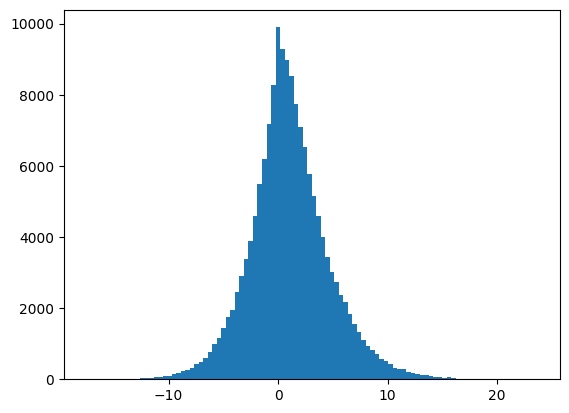

In [5]:
# plot a histogram of the reward difference
import matplotlib.pyplot as plt
plt.hist(reward_diff, bins=100)
plt.show()

In [9]:
top_quantile_threshold = reward_diff.abs().quantile(0.9)

In [12]:
top_reward_diff_ind = (reward_diff.abs() > top_quantile_threshold).nonzero().squeeze()
top_reward_diff_ind
torch.save(top_reward_diff_ind, "rm_save_files/top_reward_diff_ind.pt")